In [17]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')


Data source import complete.


# Import needed modules

In [ ]:
# !pip install tensorflow==2.18.0

In [18]:
# import system libs
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print('modules loaded')
print(f"TensorFlow version: {tf.__version__}")


modules loaded
TensorFlow version: 2.18.0


# **Data Preprocessing**

### **Read data and store it in dataframe**

In [19]:
# Generate data paths with labels
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [20]:
# train dataframe
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df, train_size=0.6, shuffle=True, random_state=123)

# Image data generators
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

ts_gen = ImageDataGenerator(rescale=1./255.)

train_gen = tr_gen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size
)

Found 4172 validated image filenames belonging to 2 classes.
Found 626 validated image filenames belonging to 2 classes.
Found 418 validated image filenames belonging to 2 classes.


In [22]:
# Model Building
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True # Fine-tune the base model

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
# Callbacks
checkpoint = ModelCheckpoint('pneumonia_detection_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)

history = model.fit(
    train_gen,
    epochs=25,
    validation_data=valid_gen,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.8763 - loss: 0.3064
Epoch 1: val_accuracy improved from -inf to 0.26198, saving model to pneumonia_detection_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8767 - loss: 0.3056 - val_accuracy: 0.2620 - val_loss: 0.7968 - learning_rate: 1.0000e-04
Epoch 2/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.9512 - loss: 0.1243
Epoch 2: val_accuracy improved from 0.26198 to 0.33866, saving model to pneumonia_detection_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 670ms/step - accuracy: 0.9512 - loss: 0.1242 - val_accuracy: 0.3387 - val_loss: 0.8803 - learning_rate: 1.0000e-04
Epoch 3/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9691 - loss: 0.0816
Epoch 3: val_accuracy improved from 0.33866 to 0.70927, saving model to pneumonia_detection_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 87s 664ms/step - accuracy: 0.9691 - loss: 0.0816 - val_accuracy: 0.7093 - val_loss: 1.4371 - learning_ra

Evaluating the model on the test set...
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 788ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.88      0.92      0.90        99
   PNEUMONIA       0.97      0.96      0.97       319

    accuracy                           0.95       418
   macro avg       0.93      0.94      0.93       418
weighted avg       0.95      0.95      0.95       418


Confusion Matrix:


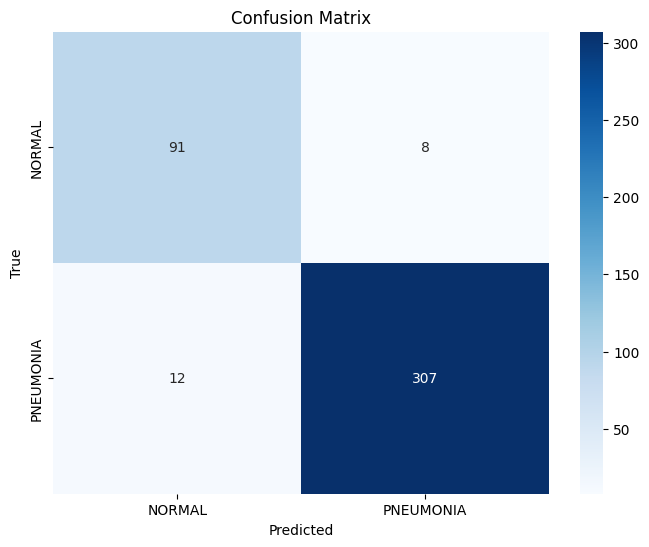

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('pneumonia_detection_model.keras')

def test_model(model, test_generator):
    """
    Tests the trained model on the test set and prints the classification
    report and confusion matrix.

    Args:
        model: The trained Keras model.
        test_generator: The test data generator.
    """
    print("Evaluating the model on the test set...")
    y_pred = model.predict(test_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(test_generator.class_indices.keys()),
                yticklabels=list(test_generator.class_indices.keys()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
test_model(best_model, test_gen)

### **Create image data generator**

Loading the saved model...
Testing on random images from the test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


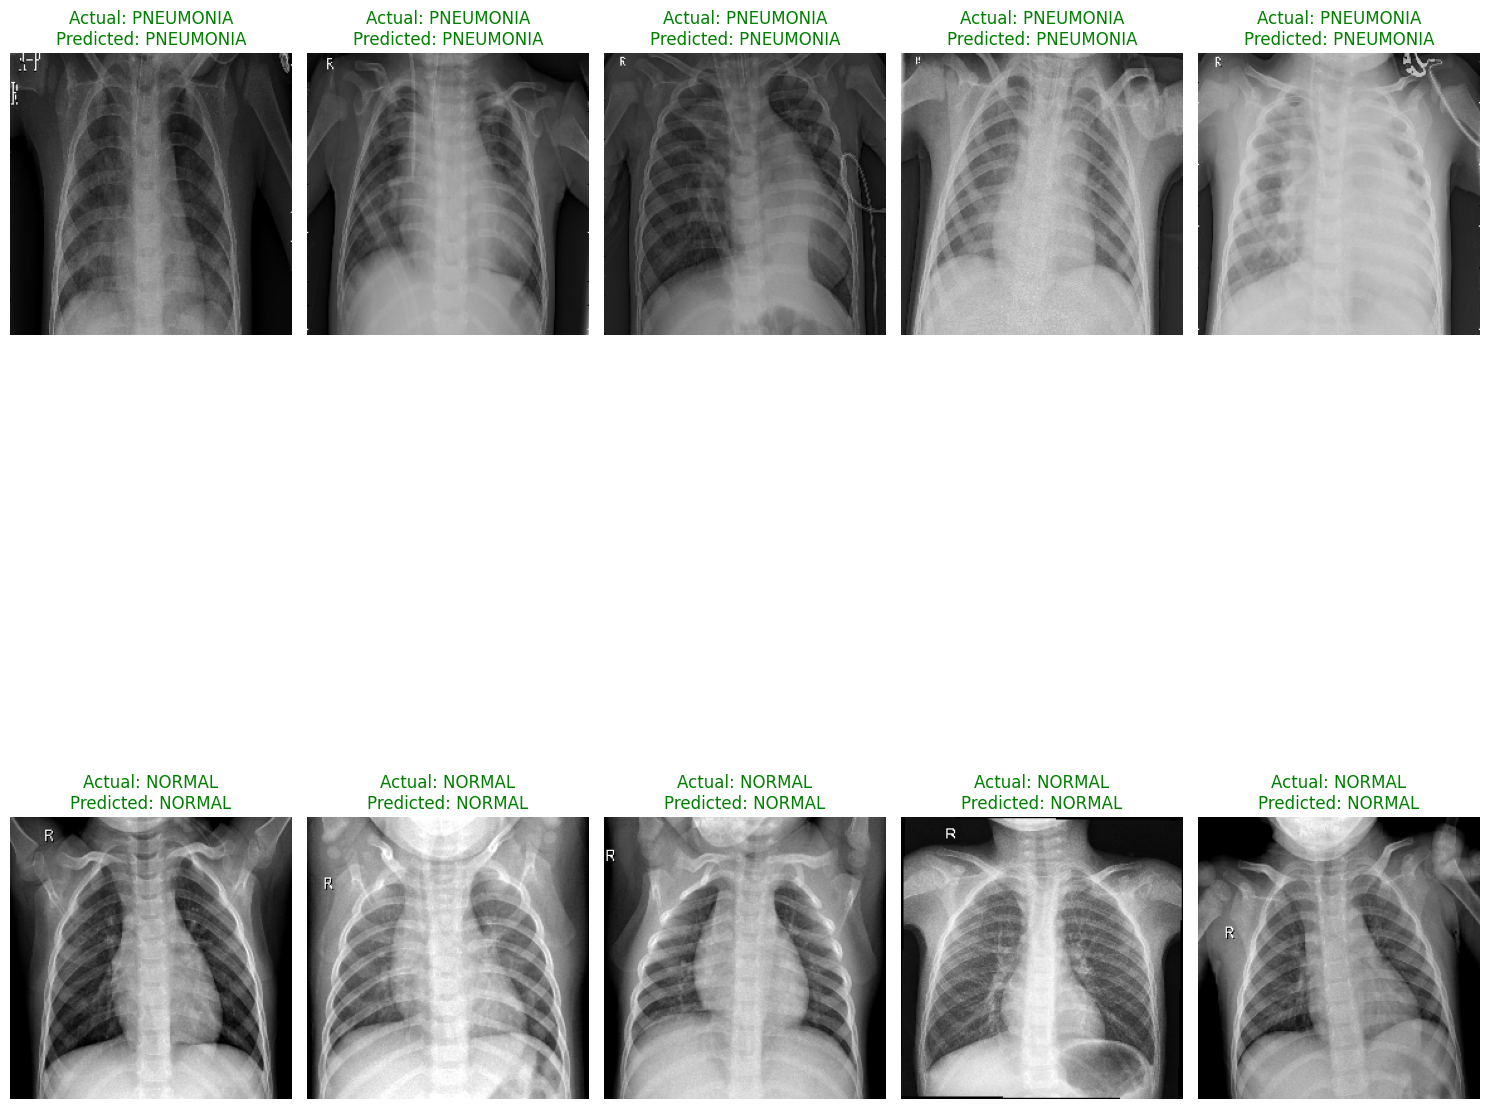

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

def test_on_random_images(model, test_df, num_images_per_class=5):
    """
    Selects random images from the test set, makes predictions, and displays the results.

    Args:
        model: The trained Keras model.
        test_df (pd.DataFrame): DataFrame containing filepaths and labels for the test set.
        num_images_per_class (int): Number of random images to test from each class.
    """
    # Get the class names from the 'labels' column
    class_names = test_df['labels'].unique()

    class_map = {'NORMAL': 0, 'PNEUMONIA': 1}
    inv_class_map = {v: k for k, v in class_map.items()}

    plt.figure(figsize=(15, 4 * num_images_per_class))
    plot_index = 1

    for class_name in class_names:
        # Get random image filepaths for the current class
        class_df = test_df[test_df['labels'] == class_name]
        random_images = class_df.sample(n=num_images_per_class, random_state=42)

        for _, row in random_images.iterrows():
            img_path = row['filepaths']
            actual_label = row['labels']

            # Load and preprocess the image
            img = image.load_img(img_path, target_size=(224, 224), color_mode='rgb')
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0  # Rescale the image

            # Make a prediction
            prediction = model.predict(img_array)
            predicted_class_index = np.argmax(prediction, axis=1)[0]
            predicted_label = inv_class_map[predicted_class_index]

            # Display the image
            plt.subplot(len(class_names), num_images_per_class, plot_index)
            plt.imshow(img)
            plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}",
                      color=("green" if actual_label == predicted_label else "red"))
            plt.axis('off')
            plot_index += 1

    plt.tight_layout()
    plt.show()

# 1. Load your best saved model
print("Loading the saved model...")
best_model = load_model('pneumonia_detection_model.keras')

# 2. Call the function with the loaded model and your test dataframe
print("Testing on random images from the test set...")
test_on_random_images(best_model, test_df, num_images_per_class=5)